<font size="+3"><mark>Compute and interpret the d_{symb} distance on the gait data set</mark></font>

---
# Introduction

## README

- GitHub repository: https://github.com/sylvaincom/d-symb
- Reproduce the following paper:
  - S. W. Combettes, C. Truong, and L. Oudre. An Interpretable Distance Measure for Multivariate Non-Stationary Physiological Signals. In _Proceedings of the International Conference on Data Mining Workshops (ICDMW)_, Shanghai, China, 2023.
- This code allows you to
  - use the $d_{symb}$ representation and distance measure
  - reproduce the results of the paper: scores and plots
    - note that, compared to the paper, in this notebook, the signal indexes have been re-ordered so that they are ordered by their class (pathology group), hence the signal indexes are not exactly the same, and as a consequence the symbol labels and symbol colors are not strictly identical, but the mindset is the same! The scores are the same, but the symbol index (and their colors) may differ.
    - note that, as the computation of the distance matrices of DTW-D and DTW-I is long (on a Macbook M1: around 30 sec for $d_{symb}$, around 4.5 hours for DTW-D, 18 hours for DTW-I), we recommend you to directly upload the results we computed for you using this same notebook

## Imports

In [1]:
import json
import pickle
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from plotly import express as px
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.utils import Bunch

from symbolic_signal_distance import SymbolicSignalDistance

pairwise_dist = SymbolicSignalDistance.pairwise_dist

import plotly.colors as pc
from tslearn.metrics import dtw as dtw_d_tslearn

from utils import define_file_paths
from utils_distances import baseline_distance, dtw_i_tslearn
from utils_interpret_distance_dsymb import (
    array2df,
    compute_silhouette_score,
    get_cluster_centers,
    get_list_ranks_of_opposing_focus,
    get_nearest_neighbors,
    get_rank_of_opposing_foot,
    get_ranks_of_opposing_feet,
    get_signal_index_of_label_change,
    get_spectrogram_from_signal,
    plot_color_bar_final,
    plot_dendrogram,
    plot_power_spectral_density,
    plot_single_color_bar,
    plot_spectrogram_with_ruptures,
    retrieve_opposing_foot,
)
from utils_load_data import load_preprocess_gait
from utils_plot import (
    plot_heatmap,
    plot_new_ordering,
    plot_raw_multivariate_signal,
    plot_univariate_signal,
)
from utils_run_distance_matrices import add_features_bunch, compute_dsymb

## Configuration parameters

In [2]:
# Setting the d_symb method
METHOD_NAME = "dsymb"
PEN_FACTOR = 1
N_SYMBOLS = 9

# Specific to the gait data set
SAMPLING_FREQUENCY = 100  # Hz
WIN_SIZE = 300  # 3 seconds
FREQUENCY_THRESHOLD = 5  # Hz

# Specific to this experiment
DATE_EXP = "2023_12_01"  # date of launch of the experiment (for versioning)
DATASET_NAME = "gait"
IS_SAVE_FIG = False  # boolean, export the plots or not
VERBOSE = True  # boolean, put `False` if you do not want any details (print, plots, etc.)
recording_index_plot = 3  # recording index to investigate by default
s = 3  # signal index to investigate by default

# Plotting configuration
sns.set()
plt.rcParams["figure.figsize"] = [6, 3]
cmap = matplotlib.colormaps['RdYlGn_r']
color_palette = {'orthopedic': "rgb(228, 26, 28)", 'neurological': "rgb(253, 180, 98)"}

---
# Load the gait signals and get their spectrograms

In the following, we load the gait data set and preprocess it.

In [3]:
# Load and preprocess the gait data set, its computed spectrograms, its metadata (age of the patient, etc), etc
b_gait = load_preprocess_gait(
    sampling_frequency=SAMPLING_FREQUENCY,
    win_size=WIN_SIZE,
    frequency_threshold=FREQUENCY_THRESHOLD
)

list_of_unscaled_univariate_signals_left = b_gait.list_of_unscaled_univariate_signals_left
list_of_unscaled_univariate_signals_right = b_gait.list_of_unscaled_univariate_signals_right
list_of_unscaled_univariate_gait_signals = b_gait.list_of_unscaled_univariate_gait_signals
df_metadata_unsorted = b_gait.df_metadata_unsorted
df_metadata = b_gait.df_metadata
mapping_signal_indexes_new_to_raw = b_gait.mapping_signal_indexes_new_to_raw
unsorted_list_of_unscaled_univariate_gait_signals = b_gait.unsorted_list_of_unscaled_univariate_gait_signals
list_of_scaled_univariate_gait_signals = b_gait.list_of_scaled_univariate_gait_signals
list_of_scaled_univariate_signals_left = b_gait.list_of_scaled_univariate_signals_left
list_of_scaled_univariate_signals_right = b_gait.list_of_scaled_univariate_signals_right
list_of_multivariate_spectrogram_signals = b_gait.list_of_multivariate_spectrogram_signals
list_of_filtered_scaled_univariate_gait_signals = b_gait.list_of_filtered_scaled_univariate_gait_signals

In the following, we will manipulate these variables to make them clearer.

## Raw unscaled gait signals

Recording index (out of 221): 3
Number of samples: 1938


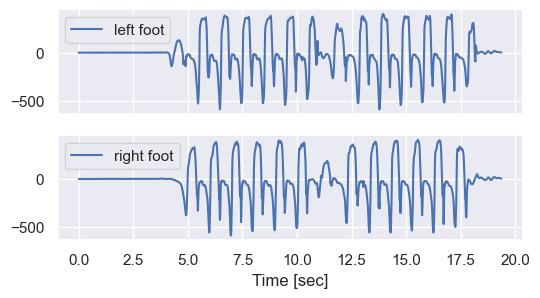

In [4]:
# Plot a recording: corresponding left and right feet signals
plot_raw_multivariate_signal(
    recording_index=recording_index_plot,
    list_of_univariate_signals_left=list_of_unscaled_univariate_signals_left,
    list_of_univariate_signals_right=list_of_unscaled_univariate_signals_right,
    sampling_frequency=SAMPLING_FREQUENCY,
)

## Meta data

In [5]:
# Display the metadata information (nevermind the `signal_index_raw` feature)
display(df_metadata.head())
print("Total number of gait signals", df_metadata["signal_index_raw"].nunique())
print("Total number of recordings", df_metadata["recording_index"].nunique())

,signal_index,signal_index_raw,recording_index,age,label,meta_label,foot,n_samples
0,0,0,0,18,T,healthy,left,2008
1,1,1,1,18,T,healthy,left,2075
2,2,2,2,18,T,healthy,left,1853
3,3,3,3,18,T,healthy,left,1938
4,4,4,4,18,T,healthy,left,1913


Total number of gait signals 442
Total number of recordings 221


In [6]:
# Sanity check of the re-ordering of the signal indexes
# (the signal indexes were re-ordered according to their class / pathology group)
if VERBOSE:
    np.random.seed(0)
    display(df_metadata.sample(5))  # the recording index is "raw"

    mapping_signal_indexes_new_to_raw = df_metadata["signal_index_raw"].tolist()
    signal_index = 362
    print(f"{signal_index = }")
    print(f"{mapping_signal_indexes_new_to_raw[signal_index] = }")

,signal_index,signal_index_raw,recording_index,age,label,meta_label,foot,n_samples
362,362,410,189,40,T,healthy,right,2331
249,249,280,59,38,T,healthy,right,1909
271,271,304,83,19,T,healthy,right,2238
435,435,151,151,70,Genou,orthopedic,left,4104
400,400,139,139,68,LER,neurological,left,2834


signal_index = 362
mapping_signal_indexes_new_to_raw[signal_index] = 410


In [7]:
# Sanity check of the re-ordering
if VERBOSE:
    print(f"{signal_index = }")
    signal_index_raw = mapping_signal_indexes_new_to_raw[signal_index]
    print(f"{signal_index_raw = }")
    display(df_metadata.query(f"signal_index == {signal_index}"))
    print("Are the signals identical?", np.allclose(
        unsorted_list_of_unscaled_univariate_gait_signals[signal_index_raw],  # before sorting
        list_of_unscaled_univariate_gait_signals[signal_index]  # after sorting
    ))

signal_index = 362
signal_index_raw = 410


,signal_index,signal_index_raw,recording_index,age,label,meta_label,foot,n_samples
362,362,410,189,40,T,healthy,right,2331


Are the signals identical? True


[384, 426]


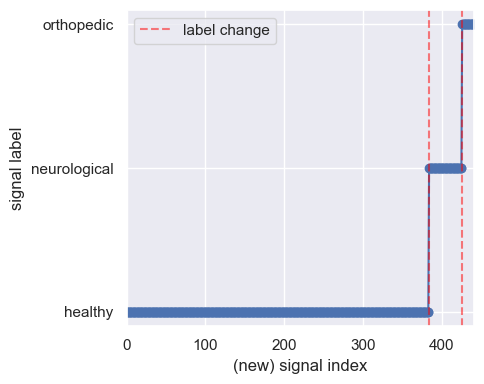

In [8]:
# Checking that signals are ordered by their class
if VERBOSE:
    str_label = "meta_label"
    label_changing_indexes = get_signal_index_of_label_change(df_metadata, str_label)
    plot_new_ordering(df_metadata, str_label, label_changing_indexes)

## Exploring the metadata

In [9]:
if VERBOSE:
    fig = px.histogram(
        df_metadata,
        x="meta_label",
        color="label",
        color_discrete_map=color_palette
    )
    fig.update_layout(
        width=600,
        height=250,
        xaxis_title="Pathology group",
        legend_title="Pathology",
        margin=dict(l=0, r=0, t=0, b=0),
    )
    fig.show()
    print("Observation: There are mostly recordings of healthy patients (class imbalance).")

Observation: There are mostly recordings of healthy patients (class imbalance).


In [10]:
if VERBOSE:
    fig = px.histogram(
        df_metadata,
        x="n_samples",
        color="meta_label",
        color_discrete_map=color_palette
    )
    fig.update_layout(
        width=600,
        height=250,
        xaxis_title="Number of samples",
        legend_title="Pathology group",
        margin=dict(l=0, r=0, t=0, b=0),
    )
    fig.show()
    print("Observation: the recordings of healthy patients have a shorter duration.")

Observation: the recordings of healthy patients have a shorter duration.


In [11]:
if VERBOSE:
    fig = px.histogram(
        df_metadata,
        x="age",
        color="meta_label",
        color_discrete_map=color_palette
    )
    fig.update_layout(
        width=600,
        height=250,
        xaxis_title="Age",
        legend_title="Pathology group",
        margin=dict(l=0, r=0, t=0, b=0),
    )
    fig.show()
    print("Observation: young people tend to be healthier.")

Observation: young people tend to be healthier.


In [12]:
if VERBOSE:
    fig = px.histogram(
        df_metadata,
        x="age",
        color="label",
        color_discrete_map=color_palette
    )
    fig.update_layout(
        width=600,
        height=250,
        xaxis_title="Age",
        legend_title="Pathology",
        margin=dict(l=0, r=0, t=0, b=0),
    )
    fig.show()
    print("Observation: young people tend to be healthier.")

Observation: young people tend to be healthier.


## Sanity check: scaling of the univariate signals

In [13]:
# Sanity check: normalization of a univariate signal
if VERBOSE:
    print(f"{s = }")

    unscaled_univariate_signal = list_of_unscaled_univariate_gait_signals[s]
    print(f"\n{unscaled_univariate_signal.shape = }")
    print(f"{np.round(np.mean(unscaled_univariate_signal), 2) = }")
    print(f"{np.round(np.std(unscaled_univariate_signal), 2) = }")
    scaled_univariate_signal = list_of_scaled_univariate_gait_signals[s]
    print(f"\n{scaled_univariate_signal.shape = }")
    print("Is the mean zero?", np.allclose(np.mean(scaled_univariate_signal), 0))
    print("Is the std zero?", np.allclose(np.std(scaled_univariate_signal), 1))

s = 3

unscaled_univariate_signal.shape = (1938,)
np.round(np.mean(unscaled_univariate_signal), 2) = 0.32
np.round(np.std(unscaled_univariate_signal), 2) = 205.7

scaled_univariate_signal.shape = (1938,)
Is the mean zero? True
Is the std zero? True


s = 3


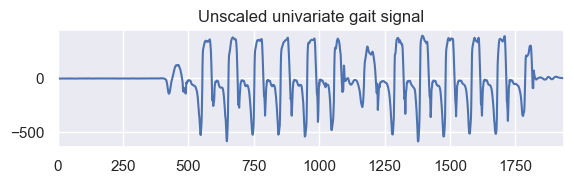

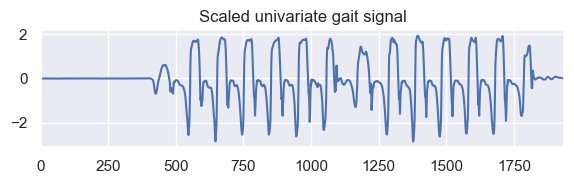

In [14]:
# Sanity check: does the scaling visually makes sense:
if VERBOSE:
    print(f"{s = }")
    plot_univariate_signal(list_of_unscaled_univariate_gait_signals[s], str_title="Unscaled univariate gait signal")
    plot_univariate_signal(list_of_scaled_univariate_gait_signals[s], str_title="Scaled univariate gait signal")

It corresponds to Figure 3 of the paper.

Recording index (out of 221): 3
Number of samples: 1938


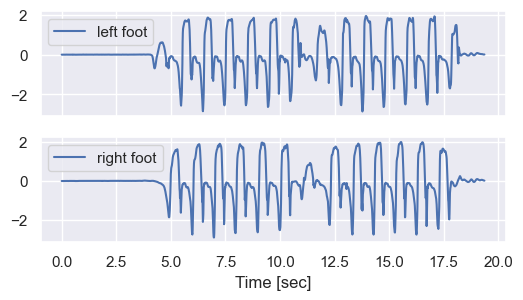

In [15]:
# Plotting two scaled corresponding left and right feet signals

print("It corresponds to Figure 3 of the paper.\n")

plot_raw_multivariate_signal(
    recording_index=s,
    list_of_univariate_signals_left=list_of_scaled_univariate_signals_left,
    list_of_univariate_signals_right=list_of_scaled_univariate_signals_right,
    sampling_frequency=SAMPLING_FREQUENCY,
    is_savefig=IS_SAVE_FIG,
    date_exp=DATE_EXP,
)

## Spectograms (multivariate signals) from the univariate gait signals

s = 3
multivariate_signal.shape = (1938, 16)


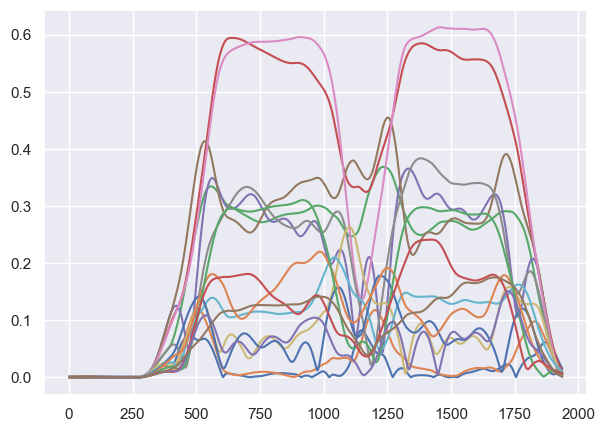

In [16]:
# Plotting the multivariate signal behind a (filtered) spectrogram
if VERBOSE:
    print(f"{s = }")

    multivariate_signal = list_of_multivariate_spectrogram_signals[s]
    print(f"{multivariate_signal.shape = }")
    plt.figure(figsize=(7, 5))
    plt.plot(multivariate_signal)
    plt.show()

## Get the scaled univariate gait signal reconstruction through a STFT with a threshold

s = 3


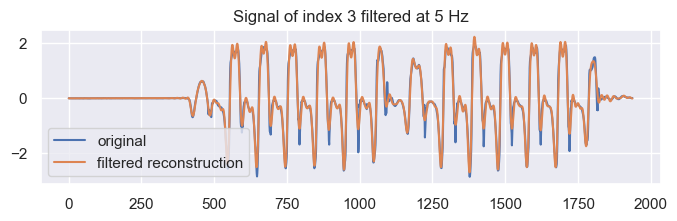

In [17]:
# Visualizing the impact of the filtering
if VERBOSE:
    print(f"{s = }")

    plt.figure(figsize=(8, 2))
    plt.plot(list_of_scaled_univariate_gait_signals[s], label="original")
    plt.plot(list_of_filtered_scaled_univariate_gait_signals[s], label="filtered reconstruction")
    plt.legend()
    plt.title(f"Signal of index {s} filtered at {FREQUENCY_THRESHOLD} Hz")
    plt.show()

## Recap of the (useful) variables

In [18]:
print(len(list_of_unscaled_univariate_gait_signals))
print(len(list_of_scaled_univariate_gait_signals))
print(len(list_of_multivariate_spectrogram_signals))
print(len(list_of_filtered_scaled_univariate_gait_signals))
print(len(df_metadata))

442
442
442
442
442


---
# Compute the pairwise distance matrices: $d_{symb}$, DTW-D, and DTW-I

Note that, in our paper, the DTW implementations are the ones from `tslearn`.

We also compute the baseline distance simply corresponds to the difference in lengths.

## $d_{symb}$

In [19]:
# Compute the pairwise distance matrix using our proposed dsymb method

b_dsymb = Bunch(name="dsymb")
b_dsymb = define_file_paths(
    b_dsymb=b_dsymb,
    date_exp=DATE_EXP,
    dataset_name=DATASET_NAME,
    pen_factor=PEN_FACTOR,
    n_symbols=N_SYMBOLS,
)
b_compute_distance_matrix_dsymb = compute_dsymb(
    b_dsymb=b_dsymb,
    list_of_multivariate_signals=list_of_multivariate_spectrogram_signals,
    pen_factor=PEN_FACTOR,
    n_symbols=N_SYMBOLS,
)
b_dsymb = add_features_bunch(b_dsymb, b_compute_distance_matrix_dsymb)

print(
    f"\nShape of the distance matrix:\n\t{b_compute_distance_matrix_dsymb.distance_matrix.shape}"
)
print(
    f"Shape of the look-up table:\n\t{b_dsymb.lookup_table.shape}"
)

The distance matrix for dsymb had already been computed. The results are loaded.

Shape of the distance matrix:
	(442, 442)
Shape of the look-up table:
	(9, 9)


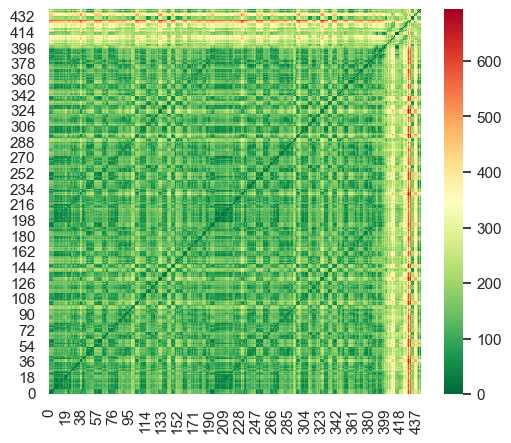

In [20]:
if VERBOSE:
    plot_heatmap(b_dsymb.distance_matrix, cmap=cmap)

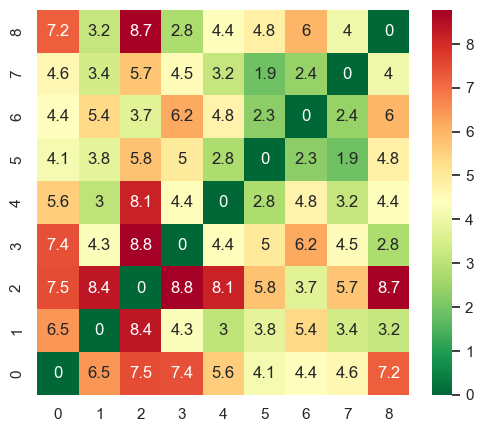

In [21]:
if VERBOSE:
    plot_heatmap(b_dsymb.lookup_table, annot=True, cmap=cmap)

In [22]:
if VERBOSE:
    display(b_dsymb.features_with_symbols_labels_df.head())
    print("Number of symbolic signals:", len(b_dsymb.list_of_symbolic_signals))

,dim_0_mean_feat,dim_1_mean_feat,dim_2_mean_feat,dim_3_mean_feat,dim_4_mean_feat,dim_5_mean_feat,dim_6_mean_feat,dim_7_mean_feat,dim_8_mean_feat,dim_9_mean_feat,...,dim_11_mean_feat,dim_12_mean_feat,dim_13_mean_feat,dim_14_mean_feat,dim_15_mean_feat,signal_index,segment_start,segment_end,segment_length,segment_symbol
0,0.012551,0.013220,0.012013,0.010321,0.008929,0.007927,0.008346,0.007567,0.005517,0.003822,...,0.002831,0.002352,0.001954,0.001557,0.001143,0,0,426,426,2
1,0.064652,0.107151,0.257016,0.334186,0.284185,0.273847,0.265222,0.152039,0.072253,0.062551,...,0.108722,0.099180,0.054494,0.030774,0.018807,0,426,524,98,5
2,0.005720,0.012986,0.297625,0.560802,0.272715,0.328319,0.580575,0.279348,0.069390,0.109219,...,0.176488,0.284006,0.128159,0.069423,0.104123,0,524,1091,567,3
3,0.014820,0.058392,0.334406,0.388775,0.190665,0.350766,0.248160,0.267750,0.125781,0.121411,...,0.151389,0.144675,0.098467,0.054409,0.096612,0,1091,1227,136,4
4,0.012375,0.015140,0.298365,0.542063,0.267791,0.340516,0.567041,0.255940,0.084798,0.125779,...,0.191946,0.276482,0.109657,0.092131,0.123117,0,1227,1756,529,3


Number of symbolic signals: 442


## Baseline distance

In [23]:
# Baseline
b_baseline = Bunch(
    name="baseline",
    distance_matrix=pairwise_dist(list_of_multivariate_spectrogram_signals, baseline_distance)
)

In [24]:
b_baseline.distance_matrix.shape

(442, 442)

## DTW-D

In [25]:
# DTW-D distance matrix
b_dtw_d = Bunch(
    name="DTW-D",
    file_str="dtw_d",
    distance_matrix_file=b_dsymb.folder_distance_matrices / "gait_dtw_d_tslearn.npy"
)
if b_dtw_d.distance_matrix_file.is_file():
    print("DTW-D had already been computed.")
    b_dtw_d.distance_matrix = np.load(b_dtw_d.distance_matrix_file)
else:
    print("DTW-D will be computed.")
    b_dtw_d.distance_matrix = pairwise_dist(list_of_multivariate_spectrogram_signals, dtw_d_tslearn)
    np.save(b_dtw_d.distance_matrix_file, b_dtw_d.distance_matrix)
    print("DTW-D has just been computed and exported.")

DTW-D had already been computed.


## DTW-I

In [26]:
# DTW-I distance matrix
b_dtw_i = Bunch(
    name="DTW-I",
    file_str="dtw_i",
    distance_matrix_file=b_dsymb.folder_distance_matrices / "gait_dtw_i_tslearn.npy"
)
if b_dtw_i.distance_matrix_file.is_file():
    print("DTW-I had already been computed.")
    b_dtw_i.distance_matrix = np.load(b_dtw_i.distance_matrix_file)
else:
    # print("DTW-I will be computed.")
    b_dtw_i.distance_matrix = pairwise_dist(list_of_multivariate_spectrogram_signals, dtw_i_tslearn)
    np.save(b_dtw_i.distance_matrix_file, b_dtw_i.distance_matrix)
    print("DTW-I has just been computed and exported.")

DTW-I had already been computed.


## Get the list of symbolic sequences (without replication)

In [27]:
b_dsymb.list_of_unreplicated_symbolic_signals = list()
for (signal_index, group) in b_dsymb.features_with_symbols_labels_df.groupby(by=["signal_index"]):
    b_dsymb.list_of_unreplicated_symbolic_signals.append(group.segment_symbol.tolist())

## Get the list of breakpoints per signal

In [28]:
b_dsymb.list_of_bkps = list()
for (_, group) in b_dsymb.features_with_symbols_labels_df.groupby("signal_index"):
    b_dsymb.list_of_bkps.append(list(group.segment_end.astype(int)))

## Recap of the variables

In [29]:
print(f"{b_dsymb.distance_matrix.shape = }")
print(f"{b_dsymb.lookup_table.shape = }")
print(f"{len(b_dsymb.features_with_symbols_labels_df) = }")
print(f"{len(b_dsymb.list_of_symbolic_signals) = }")
print(f"{len(b_dsymb.list_of_unreplicated_symbolic_signals) = }")
print(f"{len(b_dsymb.list_of_bkps) = }")

print(f"{b_dtw_d.keys() = }")
print(f"{b_dtw_i.keys() = }")

b_dsymb.distance_matrix.shape = (442, 442)
b_dsymb.lookup_table.shape = (9, 9)
len(b_dsymb.features_with_symbols_labels_df) = 3180
len(b_dsymb.list_of_symbolic_signals) = 442
len(b_dsymb.list_of_unreplicated_symbolic_signals) = 442
len(b_dsymb.list_of_bkps) = 442
b_dtw_d.keys() = dict_keys(['name', 'file_str', 'distance_matrix_file', 'distance_matrix'])
b_dtw_i.keys() = dict_keys(['name', 'file_str', 'distance_matrix_file', 'distance_matrix'])


---
# Investigate $d_{symb}$'s segmentation

## Interpret the obtained breakpoints

In [30]:
# Add the number of segments to the metadata
df_nsegments = (
    b_dsymb.features_with_symbols_labels_df[["signal_index", "segment_start"]]
    .groupby(by=["signal_index"])
    .count()
    .reset_index()
    .rename(columns={"segment_start":"n_segments"})
)
df_metadata = df_metadata.merge(df_nsegments, on=["signal_index"], how="left")

Mean number of samples: 2283


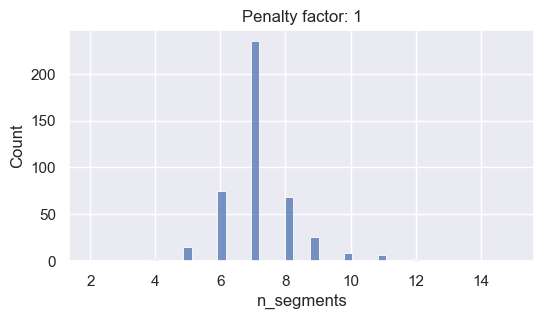

In [31]:
# Histogram of the number of segments
if VERBOSE:
    print("Mean number of samples:", round(df_metadata["n_samples"].mean()))

    sns.histplot(data=df_metadata, x="n_segments")
    plt.title(f"Penalty factor: {PEN_FACTOR:,}")
    plt.show()

In [32]:
# Add the segment length to the metadata
df_segment_length = (
    b_dsymb.features_with_symbols_labels_df[["signal_index", "segment_length"]]
    .groupby(by=["signal_index"])
    .mean()
    .reset_index()
    .rename(columns={"segment_length":"segment_length_mean"})
)
df_metadata = df_metadata.merge(df_segment_length, on=["signal_index"], how="left")

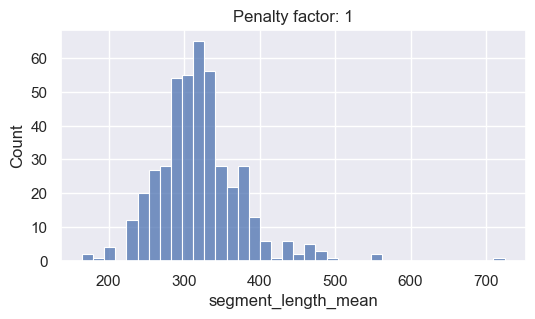

In [33]:
# Histogram of the mean segment lengths
if VERBOSE:
    sns.histplot(data=df_metadata, x="segment_length_mean")
    plt.title(f"Penalty factor: {PEN_FACTOR:,}")
    plt.show()

list_of_multivariate_spectrogram_signals[s].shape = (1938, 16)


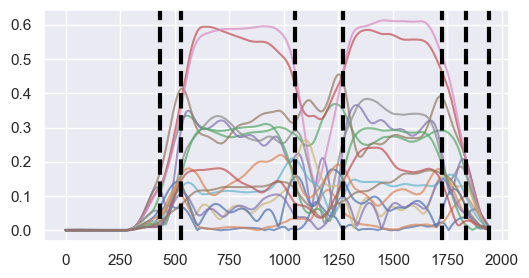

In [34]:
# Observing the ruptures on the multivariate spectrogram gait signal
if VERBOSE:
    print(f"{list_of_multivariate_spectrogram_signals[s].shape = }")
    plt.figure()
    plt.plot(list_of_multivariate_spectrogram_signals[s], alpha=0.7)
    for bkp in b_dsymb.list_of_bkps[s]:
        plt.axvline(x=bkp, color="black", linestyle="--", linewidth=3)
    plt.show()

It corresponds to Figure 1 of the paper.

s_plot = 222


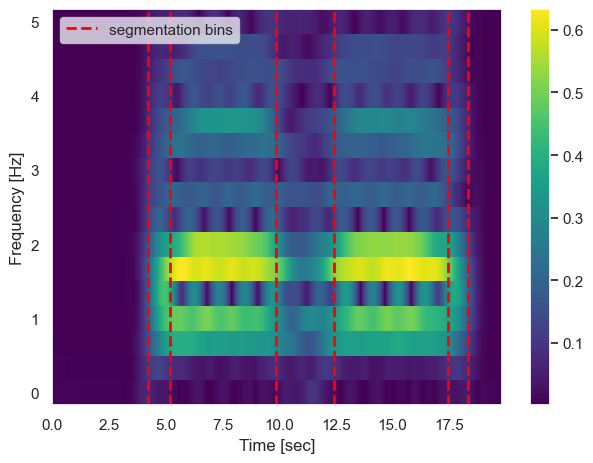

In [35]:
# Observing the ruptures on the spectrogram

print("It corresponds to Figure 1 of the paper.\n")

s_plot = 222
print(f"{s_plot = }")
scaled_univariate_gait_signal = list_of_scaled_univariate_gait_signals[s_plot]
b_get_spectrogram_from_signal = get_spectrogram_from_signal(
    scaled_univariate_gait_signal,
    SAMPLING_FREQUENCY,
    WIN_SIZE,
    FREQUENCY_THRESHOLD
)
f = b_get_spectrogram_from_signal.f
t = b_get_spectrogram_from_signal.t
Zxx = b_get_spectrogram_from_signal.Zxx
multivariate_spectrogram_signal = b_get_spectrogram_from_signal.multivariate_spectrogram_signal
plot_spectrogram_with_ruptures(
    f=f,
    t=t,
    Zxx=Zxx,
    bkps=b_dsymb.list_of_bkps[s_plot],
    is_save=IS_SAVE_FIG,
    date_exp=DATE_EXP,
    s_plot=s_plot
)

---
# Investigate $d_{symb}$'s symbolization

## Looking at the color bars

It corresponds to Figure 1 of the paper.

Symbolic sequence: [2, 5, 1, 7, 1, 5, 2]
Number of samples: 1981
signal_index = 222


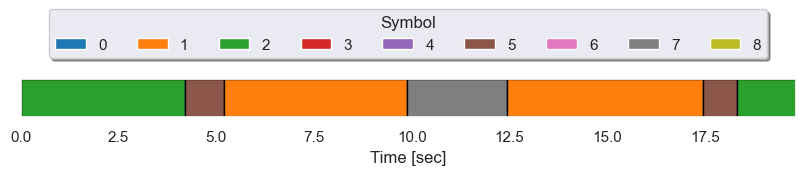

In [36]:
# for a signal signal

print("It corresponds to Figure 1 of the paper.\n")

s_plot = 222
print("Symbolic sequence:", b_dsymb.list_of_unreplicated_symbolic_signals[s_plot])
print("Number of samples:", len(list_of_scaled_univariate_gait_signals[s_plot]))
plot_single_color_bar(
    features_with_symbols_labels_df=b_dsymb.features_with_symbols_labels_df, #b_dsymb.features_with_symbols_labels_df
    signal_index=s_plot,
    n_symbols=N_SYMBOLS,
    is_display_legend=True,
    sampling_frequency=SAMPLING_FREQUENCY,
    is_savefig=IS_SAVE_FIG,
    date_exp=DATE_EXP
)

### On a subset of 60 signals

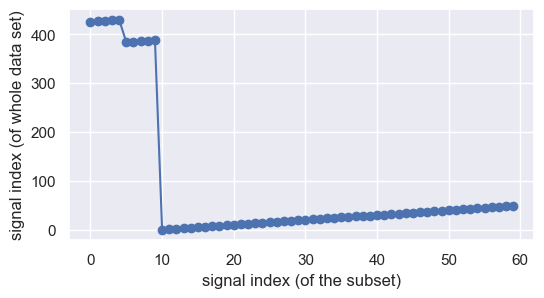

In [37]:
l_index_ortho = df_metadata.query("meta_label == 'orthopedic'")["signal_index"].unique().tolist()[0:5]
l_index_neuro = df_metadata.query("meta_label == 'neurological'")["signal_index"].unique().tolist()[0:5]
l_index_healthy = df_metadata.query("meta_label == 'healthy'")["signal_index"].unique().tolist()[0:50]
l_index_sub = l_index_ortho + l_index_neuro + l_index_healthy
df_features_with_symbols_labels_sub = b_dsymb.features_with_symbols_labels_df.query(f"signal_index in {l_index_sub}")
y_labels_sub = ["orthopedic"]*len(l_index_ortho) + ["neurological"]*len(l_index_neuro) + ["healthy"]*len(l_index_healthy)

plt.figure()
plt.plot(l_index_sub, "-o")
plt.xlabel("signal index (of the subset)")
plt.ylabel("signal index (of whole data set)")
plt.show()

#plt.plot(df_features_with_symbols_labels_sub["signal_index"].unique().tolist(), "-o");

d_replace_signal_index = dict()
for i, old_index in enumerate(l_index_sub):
    d_replace_signal_index[old_index] = i

df_features_with_symbols_labels_sub.loc[:, "signal_index"] = (
    df_features_with_symbols_labels_sub.loc[:, "signal_index"].replace(d_replace_signal_index)
)

In [38]:
y_labels_sub = df_metadata.query(f"signal_index in {l_index_sub}")["meta_label"].tolist()
le = preprocessing.LabelEncoder()
encoded_y_sub = le.fit(y_labels_sub).transform(y_labels_sub)
pd_encoded_y_sub = pd.Series(encoded_y_sub)
change_indexes_sub = pd_encoded_y_sub.index[pd_encoded_y_sub.diff() == 1].tolist()
print(change_indexes_sub)

[50, 55]


In [39]:
y_labels_sub_plot = list(le.inverse_transform(list(set(encoded_y_sub))))
#print(y_labels_sub_plot)

It corresponds to Figure 4 of the paper.



/Users/swc/Documents/PhD/code/d-symb/utils_interpret_distance_dsymb.py:621: UserWarning:

FixedFormatter should only be used together with FixedLocator



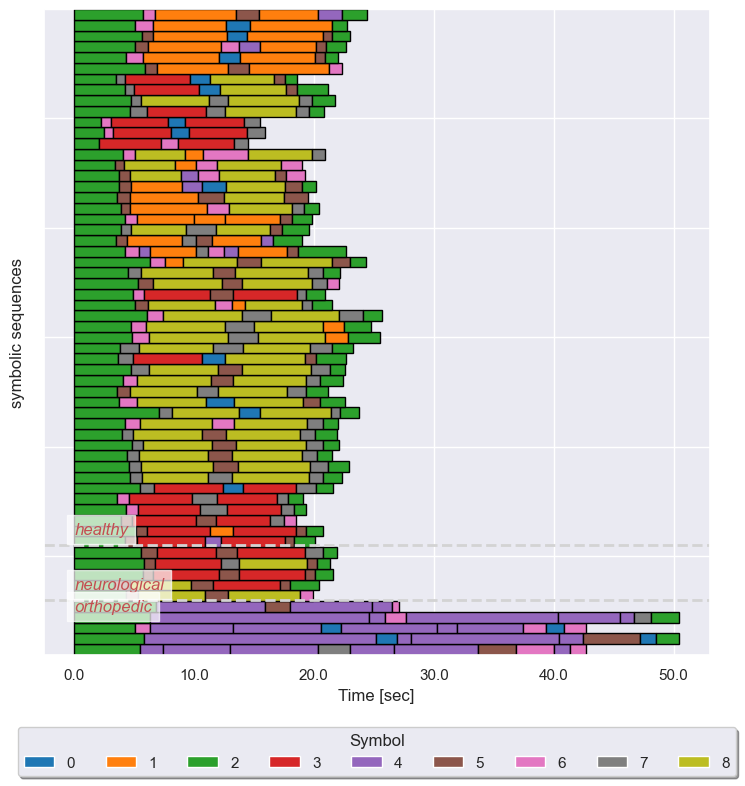

In [40]:
print("It corresponds to Figure 4 of the paper.\n")

plot_color_bar_final(
    df_features_with_symbols_labels_sub,
    is_savefig=IS_SAVE_FIG,
    date_exp=DATE_EXP,
    is_display_legend=True,
    change_indexes=[elem-1 for elem in change_indexes_sub],
    y_label=y_labels_sub,
    sampling_frequency=SAMPLING_FREQUENCY,
    is_display_border=True,
)

[2, 4, 5, 4, 4, 6]
2712
signal_index = 430


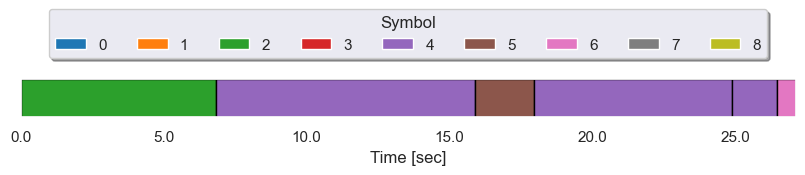

In [41]:
# Sanity check
if VERBOSE:
    s_plot = l_index_ortho[-1]
    print(b_dsymb.list_of_unreplicated_symbolic_signals[s_plot])
    print(len(list_of_scaled_univariate_gait_signals[s_plot]))
    plot_single_color_bar(
        features_with_symbols_labels_df=b_dsymb.features_with_symbols_labels_df,
        signal_index=s_plot,
        n_symbols=N_SYMBOLS,
        is_display_legend=True,
        sampling_frequency=SAMPLING_FREQUENCY,
        is_savefig=IS_SAVE_FIG,
        date_exp=DATE_EXP
    )

## Get the cluster centers / power spectral densities

In [42]:
b_dsymb = get_cluster_centers(b_dsymb=b_dsymb, n_symbols=N_SYMBOLS)

Plotting all symbols:

It corresponds to Figure 5 of the paper.



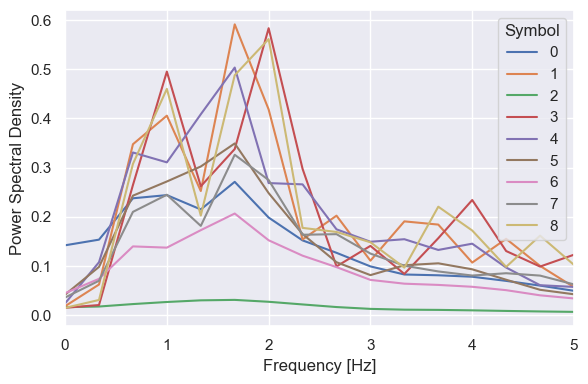

In [43]:
print("It corresponds to Figure 5 of the paper.\n")

plot_power_spectral_density(
    b_dsymb=b_dsymb,
    f=f,
    n_symbols=N_SYMBOLS,
    is_savefig=IS_SAVE_FIG,
    date_exp=DATE_EXP,
)

## Characteristics of the symbols

### Occurence

In [44]:
l_cols = ["signal_index", "segment_length", "segment_symbol"]
b_dsymb.symbols_with_metadata_df = b_dsymb.features_with_symbols_labels_df[l_cols]
b_dsymb.symbols_with_metadata_df = (
    b_dsymb.symbols_with_metadata_df.merge(df_metadata, on=["signal_index"], how="left")
)
b_dsymb.symbols_with_metadata_df.head()

,signal_index,segment_length,segment_symbol,signal_index_raw,recording_index,age,label,meta_label,foot,n_samples,n_segments,segment_length_mean
0,0,426,2,0,0,18,T,healthy,left,2008,7,286.857143
1,0,98,5,0,0,18,T,healthy,left,2008,7,286.857143
2,0,567,3,0,0,18,T,healthy,left,2008,7,286.857143
3,0,136,4,0,0,18,T,healthy,left,2008,7,286.857143
4,0,529,3,0,0,18,T,healthy,left,2008,7,286.857143


In [45]:
# Print a list of available color scales in Plotly
print(pc.PLOTLY_SCALES)

# Use the color picker to choose a color
color = pc.qualitative.Plotly[0]
print(color)

{'Greys': [[0, 'rgb(0,0,0)'], [1, 'rgb(255,255,255)']], 'YlGnBu': [[0, 'rgb(8,29,88)'], [0.125, 'rgb(37,52,148)'], [0.25, 'rgb(34,94,168)'], [0.375, 'rgb(29,145,192)'], [0.5, 'rgb(65,182,196)'], [0.625, 'rgb(127,205,187)'], [0.75, 'rgb(199,233,180)'], [0.875, 'rgb(237,248,217)'], [1, 'rgb(255,255,217)']], 'Greens': [[0, 'rgb(0,68,27)'], [0.125, 'rgb(0,109,44)'], [0.25, 'rgb(35,139,69)'], [0.375, 'rgb(65,171,93)'], [0.5, 'rgb(116,196,118)'], [0.625, 'rgb(161,217,155)'], [0.75, 'rgb(199,233,192)'], [0.875, 'rgb(229,245,224)'], [1, 'rgb(247,252,245)']], 'YlOrRd': [[0, 'rgb(128,0,38)'], [0.125, 'rgb(189,0,38)'], [0.25, 'rgb(227,26,28)'], [0.375, 'rgb(252,78,42)'], [0.5, 'rgb(253,141,60)'], [0.625, 'rgb(254,178,76)'], [0.75, 'rgb(254,217,118)'], [0.875, 'rgb(255,237,160)'], [1, 'rgb(255,255,204)']], 'Bluered': [[0, 'rgb(0,0,255)'], [1, 'rgb(255,0,0)']], 'RdBu': [[0, 'rgb(5,10,172)'], [0.35, 'rgb(106,137,247)'], [0.5, 'rgb(190,190,190)'], [0.6, 'rgb(220,170,132)'], [0.7, 'rgb(230,145,90)'], 

In [46]:
print("It corresponds to Figure 7 of the paper.\n")

plotly_color = "meta_label"  # "foot", "label", "meta_label"
color_palette = {'orthopedic': "rgb(228, 26, 28)", 'neurological': "rgb(253, 180, 98)"}
fig = px.histogram(
    b_dsymb.symbols_with_metadata_df.query("meta_label != 'healthy'"),
    # symbols_with_metadata_df_new.query("meta_label != 'healthy'"),
    x="segment_symbol",
    color=plotly_color,
    color_discrete_map=color_palette
)
fig.update_layout(
    width=900//2,
    height=300//2,
    xaxis_title="Symbol",
    legend_title="Pathology group",
    margin=dict(l=0, r=0, t=0, b=0),
    xaxis=dict(
        tickmode='linear',
        dtick=1
    )
)
if IS_SAVE_FIG:
    fig.write_image(f"results/{DATE_EXP}/img/histogram_symbol_{plotly_color}.png", width=900//2, height=300//2, scale=2)
fig.show()

It corresponds to Figure 7 of the paper.



In [47]:
print("It corresponds to Figure 7 of the paper.\n")

plotly_color = "foot"  # "foot", "label", "meta_label"
color_palette = {'left': "#3366CC", 'right': "#109618"}
fig = px.histogram(
    b_dsymb.symbols_with_metadata_df,
    x="segment_symbol",
    color=plotly_color,
    color_discrete_map=color_palette
)
fig.update_layout(
    width=900//2,
    height=300//2,
    xaxis_title="Symbol",
    legend_title="Laterality",
    margin=dict(l=0, r=0, t=0, b=0),
    xaxis=dict(
        tickmode='linear',
        dtick=1
    )
)
if IS_SAVE_FIG:
    fig.write_image(
        f"results/{DATE_EXP}/img/histogram_symbol_{plotly_color}.png", width=900//2, height=300//2, scale=2
    )
fig.show()

It corresponds to Figure 7 of the paper.



## Clustering of the symbols based on the lookup table

Try to find which symbols correspond to the same phenomenon.

It corresponds to Figure 6.



/Users/swc/opt/anaconda3/envs/mastride/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:364: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



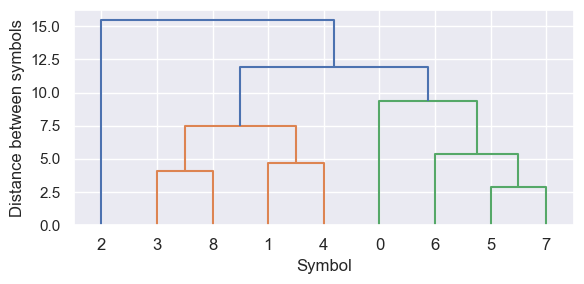

In [48]:
print("It corresponds to Figure 6.\n")

plot_dendrogram(b_dsymb.lookup_table, IS_SAVE_FIG, DATE_EXP)

---
# Investigate $d_{symb}$'s distance

We no longer look into the distance between symbols, but the distance between symbolic signals.

## Signals that are close according to $d_{symb}$, but far according to the baseline

Baseline says `s1` and `s2` are different, while $d_{symb}$ says they are similar.

In [49]:
print("Its corresponds to the second experiment of the paper in section V.B.\n")

s1, s2 = 211, 327

signal_s1 = list_of_scaled_univariate_gait_signals[s1]
signal_s2 = list_of_scaled_univariate_gait_signals[s2]
print("Length of the first signal:", len(signal_s1))
print("Length of the second signal:", len(signal_s2))

print()
print("Difference in lengths:", round(b_baseline.distance_matrix[s1, s2]))
print("Mean difference in lengths of all signals:", round(np.mean(b_baseline.distance_matrix)))
print()
print("Distance according to d_symb:", round(b_dsymb.distance_matrix[s1, s2]))
print("Mean distance according to d_symb of all signals:", round(np.mean(b_dsymb.distance_matrix)))

Its corresponds to the second experiment of the paper in section V.B.

Length of the first signal: 2550
Length of the second signal: 1994

Difference in lengths: 556
Mean difference in lengths of all signals: 468

Distance according to d_symb: 70
Mean distance according to d_symb of all signals: 155


It corresponds to Figure 8 of the paper



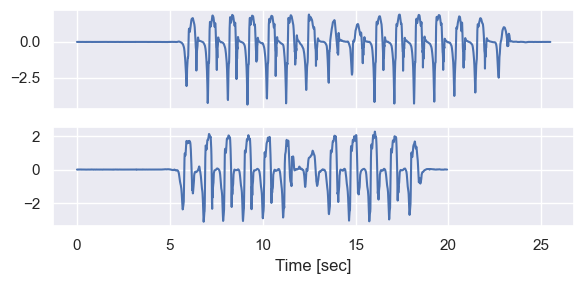

signal_index = 211


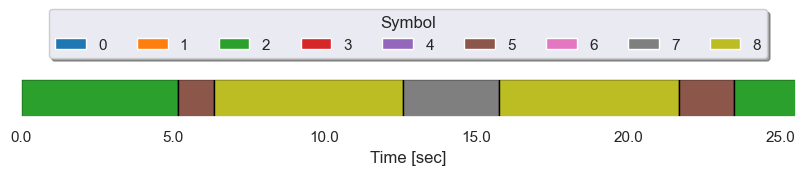

signal_index = 327


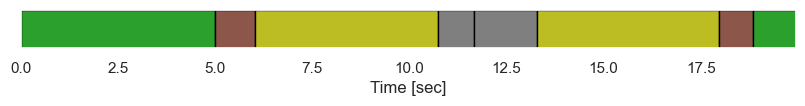

In [50]:
print(f"It corresponds to Figure 8 of the paper\n")

fig, axs = plt.subplots(2, 1, figsize=(6, 3), sharex=True)
axs[0].plot(list(np.arange(len(signal_s1)) / SAMPLING_FREQUENCY), signal_s1)
axs[1].plot(list(np.arange(len(signal_s2)) / SAMPLING_FREQUENCY), signal_s2)

plt.xlabel("Time [sec]")
plt.tight_layout()
plt.margins(x=0)
if IS_SAVE_FIG:
    plt.savefig(f"results/{DATE_EXP}/img/comparison_baseline_2.png", dpi=200)
plt.show()

plot_single_color_bar(
    features_with_symbols_labels_df=b_dsymb.features_with_symbols_labels_df,
    signal_index=s1,
    n_symbols=N_SYMBOLS,
    is_display_legend=True,
    is_savefig=IS_SAVE_FIG,
    date_exp=DATE_EXP,
)
plot_single_color_bar(
    features_with_symbols_labels_df=b_dsymb.features_with_symbols_labels_df,
    signal_index=s2,
    n_symbols=N_SYMBOLS,
    is_display_legend=False,
    is_savefig=IS_SAVE_FIG,
    date_exp=DATE_EXP,
)

## Silhouette score

In [51]:
distance_names = ["DTW-D", "DTW-I", "d_{symb}"]

In [52]:
b_dtw_d = compute_silhouette_score(b_dtw_d, df_metadata)
b_dtw_i = compute_silhouette_score(b_dtw_i, df_metadata)
b_dsymb = compute_silhouette_score(b_dsymb, df_metadata)

In [53]:
print(distance_names)

['DTW-D', 'DTW-I', 'd_{symb}']


In [54]:
print("It corresponds to Table 1 of the paper\n")

df_silhouette_scores = pd.DataFrame(
    [
        [b_dtw_d.silhouette_mean, b_dtw_d.silhouette_median],
        [b_dtw_i.silhouette_mean, b_dtw_i.silhouette_median],
        [b_dsymb.silhouette_mean, b_dsymb.silhouette_median],
    ]
)
df_silhouette_scores.index = distance_names
df_silhouette_scores = (
    df_silhouette_scores.rename(columns={0:"silhouette_mean", 1:"silhouette_median"})
)
display(df_silhouette_scores.round(2))

It corresponds to Table 1 of the paper



,silhouette_mean,silhouette_median
DTW-D,0.15,0.19
DTW-I,0.15,0.18
d_{symb},0.33,0.41


## Nearest neighbors (left / right)

In [55]:
print(b_dtw_d.distance_matrix.shape)
print(b_dtw_i.distance_matrix.shape)
print(b_dsymb.distance_matrix.shape)

(442, 442)
(442, 442)
(442, 442)


In [56]:
distances, indices = get_nearest_neighbors(b_dsymb.distance_matrix)

In [57]:
signal_index_retrieval = retrieve_opposing_foot(signal_index_query=311, df_metadata=df_metadata, is_print=True)
print(f"{signal_index_retrieval = }")

,signal_index,signal_index_raw,recording_index,age,label,meta_label,foot,n_samples,n_segments,segment_length_mean
119,119,130,130,38,T,healthy,left,2355,8,294.375
311,311,351,130,38,T,healthy,right,2355,8,294.375


signal_index_retrieval = 119


In [58]:
rank_opposing_foot = get_rank_of_opposing_foot(10, indices, distances, df_metadata, False)

In [59]:
b_dtw_d.list_ranks_of_opposing_feet = get_ranks_of_opposing_feet(b_dtw_d.distance_matrix, df_metadata)
b_dtw_i.list_ranks_of_opposing_feet = get_ranks_of_opposing_feet(b_dtw_i.distance_matrix, df_metadata)
b_dsymb.list_ranks_of_opposing_feet = get_ranks_of_opposing_feet(b_dsymb.distance_matrix, df_metadata)

In [60]:
signal_indexes_left = df_metadata.query("foot == 'left'")["signal_index"].tolist()
signal_indexes_right = df_metadata.query("foot == 'right'")["signal_index"].tolist()
print(len(signal_indexes_left))
print(len(signal_indexes_right))
print(len(list(set(signal_indexes_left)-set(signal_indexes_right))))

221
221
221


In [61]:
def get_list(meta_label_focus, df_metadata, distance_names, b_dsymb, b_dtw_d, b_dtw_i):
    signal_indexes_focus = df_metadata.query(f"meta_label == '{meta_label_focus}'")["signal_index"].tolist()
    print(f"Number of signals with the {meta_label_focus} meta label:", len(signal_indexes_focus))

    b_dtw_d = get_list_ranks_of_opposing_focus(b_dtw_d, signal_indexes_focus)
    b_dtw_i = get_list_ranks_of_opposing_focus(b_dtw_i, signal_indexes_focus)
    b_dsymb = get_list_ranks_of_opposing_focus(b_dsymb, signal_indexes_focus)

    df_ranks = pd.DataFrame(
        [
            [b_dtw_d.list_ranks_of_opposing_focus_mean],
            [b_dtw_i.list_ranks_of_opposing_focus_mean],
            [b_dsymb.list_ranks_of_opposing_focus_mean],
        ]
    )
    df_ranks.index = distance_names
    df_ranks = (
        df_ranks.rename(columns={0:meta_label_focus})
    )
    return df_ranks

In [62]:
df_ranks_healthy = get_list(meta_label_focus="healthy", df_metadata=df_metadata, distance_names=distance_names, b_dsymb=b_dsymb, b_dtw_d=b_dtw_d, b_dtw_i=b_dtw_i)
df_ranks_neurological = get_list(meta_label_focus="neurological", df_metadata=df_metadata, distance_names=distance_names, b_dsymb=b_dsymb, b_dtw_d=b_dtw_d, b_dtw_i=b_dtw_i)
df_ranks_orthopedic = get_list(meta_label_focus="orthopedic", df_metadata=df_metadata, distance_names=distance_names, b_dsymb=b_dsymb, b_dtw_d=b_dtw_d, b_dtw_i=b_dtw_i)

Number of signals with the healthy meta label: 384
Number of signals with the neurological meta label: 42
Number of signals with the orthopedic meta label: 16


In [63]:
print("It corresponds to Table 2 of the paper.\n")

pd.concat([df_ranks_healthy, df_ranks_neurological, df_ranks_orthopedic], axis=1).round(1)

It corresponds to Table 2 of the paper.



,healthy,neurological,orthopedic
DTW-D,15.8,19.9,6.4
DTW-I,6.7,12.6,3.9
d_{symb},9.1,5.1,2.0
